In [35]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

transform = transforms.ToTensor()

data_path = '../data_cifar/'
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

print("Training: ", len(cifar10_train)) #Training: 50000
print("Validating: ", len(cifar10_val)) #Testing: 10000

type(cifar10_train) # torchvision.datasets.cifar.CIFAR10
type(cifar10_val) # torchvision.datasets.cifar.CIFAR10

type(cifar10_train[0]) # tuple

image, label = cifar10_train[1]
type(image) # torch.Tensor
image.shape # torch.Size([3, 32, 32])

classes = cifar10_train.classes

torch.manual_seed(80)
train_loader = DataLoader(cifar10_train, batch_size=100, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=500, shuffle=False)

cifar10 = datasets.CIFAR10(data_path, download=True, train=True)
tr_images = cifar10.data
tr_targets = torch.tensor(cifar10.targets)

val_cifar10 = datasets.CIFAR10(data_path, download=True, train=False)
val_images = val_cifar10.data
val_targets = torch.tensor(val_cifar10.targets)

class CIFARDataset(Dataset):
    def __init__(self, x, y):
        x = torch.tensor(x).float()/255.0
        x = x.reshape(-1,32*32*3)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

def get_data(): 
    train = CIFARDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=100, shuffle=True)
    val = CIFARDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer
  
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

from torch import optim
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, \
                                                 patience=0, threshold = 0.001, verbose=True, \
                                                 min_lr = 1e-5, threshold_mode='rel')

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(20):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss)

    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
     

Files already downloaded and verified
Files already downloaded and verified
Training:  50000
Validating:  10000
Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
7
8
9
10
Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.
11
12
Epoch 00013: reducing learning rate of group 0 to 1.2500e-04.
13
14
Epoch 00015: reducing learning rate of group 0 to 6.2500e-05.
15
16
Epoch 00017: reducing learning rate of group 0 to 3.1250e-05.
17
18
Epoch 00019: reducing learning rate of group 0 to 1.5625e-05.
19
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.


<ipython-input-36-a0c8db768347>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


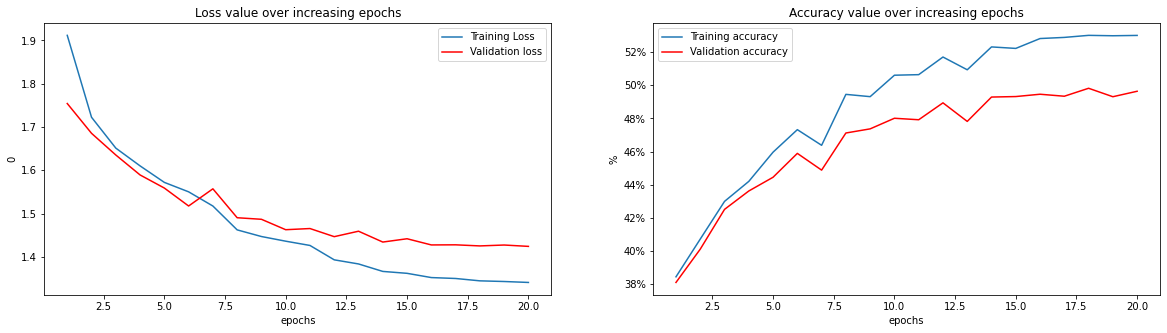

In [36]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('0')
plt.legend()

plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, train_accuracies,  label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('%')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

